In [1]:
from typing import TypedDict, Annotated, List, Literal, Dict, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
import random
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from datetime import datetime
from dotenv import load_dotenv
import os

In [2]:
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [3]:
class SupervisorState(MessagesState):
    """State for the multi-agent"""
    next_agent: str = ""
    research_data: str = ""
    analysis: str = ""
    final_report: str = ""
    task_complete: bool = False
    current_task: str = ""

In [4]:
llm = ChatGroq(model = "llama-3.3-70b-versatile")

In [5]:
def create_supervisor_chain():
    """Creates the supervisor decision chain"""
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a supervisor managing a team of agents:

1. Researcher - Gathers information and data
2. Analyst - Analyzes data and provides insights
3. Writer - Creates reports and summaries

Based on the current state and conversation, decide which agent should work next.
if the task is complete, respond with 'DONE'.

Current state:
- Has research data: {has_research}
- Has analysis: {has_analysis}
- Has report: {has_report}

Respond with ONLY the agent name (researcher/analyst/writer) or 'DONE'.
"""),
        ("human", "{task}")
    ])

    return supervisor_prompt | llm


In [37]:
def supervisor_agent(state: SupervisorState) -> Dict:
    """Supervisor decides next agent using Groq LLM"""
    messages = state["messages"]
    task = messages[-1].content if messages else "No Task"
    
    has_research = bool(state.get("research_data", ""))
    has_analysis = bool(state.get("analysis", ""))
    has_report = bool(state.get("final_report", ""))

    # In case no task is provided, default to 'research'
    if not task:
        task = "research the topic"

    chain = create_supervisor_chain()
    decision = chain.invoke({
        "task": task,
        "has_research": has_research,
        "has_analysis": has_analysis,
        "has_report": has_report
    })

    decision_text = decision.content.strip().lower()
    print(f"Supervisor decision: {decision_text}")

    if "done" in decision_text or has_report:
        next_agent = "end"
        supervisor_msg = "Supervisor: All tasks complete! Great work team."
    elif "analyst" in decision_text or (has_research and not has_analysis):
        next_agent = "analyst"
        supervisor_msg = "Supervisor: Research done. Time for analysis. Assigning to Analyst..."
    elif "writer" in decision_text or (has_analysis and not has_report):
        next_agent = "writer"
        supervisor_msg = "Supervisor: Analysis complete. Let's create the report. Assigning to Writer..."
    else:
        next_agent = "researcher"
        supervisor_msg = "Supervisor: Starting with research. Assigning to Researcher..."

    return {
        "messages": [AIMessage(content = supervisor_msg)],
        "next_agent": next_agent,
        "current_task": task
    }


In [38]:
def researcher_agent(state: SupervisorState) -> Dict:
    """Researcher uses Groq to gather information"""
    task = state.get("current_task", "research topic")
    research_prompt = f"""As a research specialist, provide comprehensive information about: {task}

    Included:
    1. Key factes and background
    2.Current trends or developments
    3. Important statistics or data studies
    4. Notable examples or case studies

    Be concise but thorough."""
    
    research_response = llm.invoke([HumanMessage(content = research_prompt)])
    research_data = research_response.content

    agent_message = f"""Researcher: I've completed the research on '{task}'. \n\nKey findings:\n{research_data}"""
    
    return {
        "messages": [AIMessage(content = agent_message)],
        "research_data": research_data,
        "next_agent": "supervisor"
    }

In [39]:
def analyst_agent(state: SupervisorState) -> Dict:
    """Analyst uses Groq to analyze the research"""
    research_data = state.get("research_data", "")
    task = state.get("current_task", "")

    analysis_prompt = f"""As a data analysis, analyze this research data and provide insights:

Research Data:
{research_data}

Provide: 
1. Key insights and pattern
2. Strategic implications
3. Risks and opportunities
4. Recommendations

Focus on actionable insights related to: {task}"""
    
    analysis_response = llm.invoke([HumanMessage(content = analysis_prompt)])
    analysis = analysis_response.content

    agent_message = f"Analyst: I've completed the analysis.\n\nTop insights:\n{analysis[:400]}..."

    return {
        "messages": [AIMessage(content = agent_message)],
        "analysis": analysis,
        "next_agent": "supervisor"
    }

In [40]:
def writer_agent(state: SupervisorState) -> Dict:
    """Writer uses Groq to create final report"""
    research_data = state.get("research_data", "")
    analysis = state.get("analysis", "")
    task = state.get("current_task", "")

    writing_prompt = f"""As a professional writer, create an executive report based on:
    
Task: {task}

Research Findings:
{research_data[:1000]}

Analysis:
{analysis[:1000]}

Create a well-structured report with:
1. Executive Summary
2. Key Findings
3. Analysis & Insights
4. Recommendations
5. Conclusion

Keep it professional and concise."""

    report_response = llm.invoke([HumanMessage(content = writing_prompt)])
    report = report_response.content

    final_report = f"""
    FINAL REPORT
{'='*50}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
Topic: {task}
{'='*50}

{report}

{'='*50}
Report compiled by Multi-Agent AI System powered by Groq
"""

    return {
        "messages": [AIMessage(content = f"Writer: Report complete! See below for the full document.")],
        "final_report": final_report,
        "next_agent": "supervisor",
        "task_complete": True
    }

In [41]:
def router(state: SupervisorState) -> Literal["supervisor", "researcher", "analyst", "writer", "__end__"]:
    """Routes to next agent based on state"""
    next_agent = state.get("next_agent", "supervisor")
    if next_agent == "end" or state.get("task_completed", False):
        return END
    if next_agent in ["supervisor", "researcher", "analyst", "writer"]:
        return next_agent
    return "supervisor"

In [42]:
workflow = StateGraph(SupervisorState)

workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("researcher", researcher_agent)
workflow.add_node("analyst", analyst_agent)
workflow.add_node("writer", writer_agent)

workflow.set_entry_point("supervisor")

for node in ["supervisor", "researcher", "analyst", "writer"]:
    workflow.add_conditional_edges(
        node,
        router,
        {
            "supervisor": "supervisor",
            "researcher": "researcher",
            "analyst": "analyst",
            "writer": "writer",
            END: END
        }
    )

graph = workflow.compile()

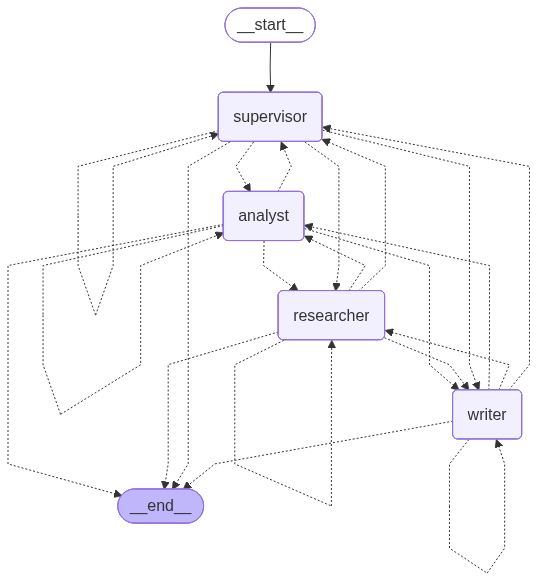

In [43]:
graph

In [45]:
response = graph.invoke(HumanMessage(content = "What are the benefits and risks of AI in healthcare?"))

Supervisor decision: researcher
Supervisor decision: analyst
Supervisor decision: writer
Supervisor decision: done


In [46]:
response

{'messages': [AIMessage(content='Supervisor: Starting with research. Assigning to Researcher...', additional_kwargs={}, response_metadata={}, id='5bff2ffb-a7cf-447f-9875-2506d29f73e4'),
  AIMessage(content="Researcher: I've completed the research on 'No Task'. \n\nKey findings:\nSince there is no specific task provided, I will outline a general framework for a research report. \n\n### 1. Key Facts and Background\n- **Definition and Purpose**: Typically, a task refers to a specific activity or piece of work to be done. Understanding the nature of tasks is crucial in various fields, including project management, psychology, and education.\n- **Historical Context**: The concept of tasks has evolved over time, influenced by technological advancements, changes in workplace dynamics, and shifts in educational methodologies.\n- **Relevance**: Tasks are fundamental in achieving goals, whether personal, academic, or professional, making their management and completion critical for success.\n\n#

In [47]:
print(response["final_report"])


    FINAL REPORT
Generated: 2025-10-08 02:25
Topic: Analyst: I've completed the analysis.

Top insights:
### 1. Key Insights and Patterns

- **Digital Transformation**: The rise of digital task management tools and the shift towards remote work underscore the importance of adapting to technological advancements in managing tasks effectively.
- **Productivity Enhancement**: Effective task management is directly linked to increased productivity, with studies indicating up to a 30% increase in productiv...

**Executive Report: Task Management Analysis**

### 1. Executive Summary
This report presents the findings of an analysis on task management, highlighting the importance of adapting to technological advancements, enhancing productivity, and promoting adaptability and innovation. The rise of digital task management tools and the shift towards remote work underscore the need for effective task management strategies. Our analysis reveals that effective task management can lead to up to a